In [1]:
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

import torch.optim as optim
from sklearn.metrics import f1_score



from torchvision.datasets import StanfordCars

from scipy.io import loadmat

import matplotlib.pyplot as plt
%matplotlib inline

import random
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


# load data from google drive

In [4]:
root_dir = Path('/content/drive/MyDrive/stanford_cars')
cars_test = root_dir / 'cars_test'
cars_train = root_dir / 'cars_train'

training_images = os.listdir(cars_train)
testing_images = os.listdir(cars_test)

cars_annos_train = root_dir / "devkit" / "cars_train_annos.mat"
cars_annos_test = root_dir / "cars_test_annos_withlabels.mat"

cars_meta_mat = loadmat(root_dir / "devkit" / "cars_meta.mat") #dict_keys(['__header__', '__version__', '__globals__', 'class_names'])
cars_annos_train_mat, cars_annos_test_mat = loadmat(cars_annos_train), loadmat(cars_annos_test) #dict_keys(['__header__', '__version__', '__globals__', 'annotations'])

class_names = [arr[0] for arr in cars_meta_mat['class_names'][0]]

# # New structure of mat file's "annotations array is going to be" 6 elements with
# # box11, box12, box21, box22, class, and filename
# cars_annos_train_mat['annotations'][0] is of shape (8144,) which is the trainig set data size
sample1 = cars_annos_train_mat['annotations'][0][0]
sample1_path, sample1_class = sample1[-1][0], sample1[-2][0][0] - 1

#### Load the google net model, modify the output layers equal to the number of classes

In [5]:
googlenet_weights = torchvision.models.GoogLeNet_Weights.DEFAULT
googlenet = torchvision.models.googlenet(weights=googlenet_weights).to(device)
googlenet_transforms = googlenet_weights.transforms()

for param in googlenet.parameters():
    param.requires_grad = False

googlenet.fc = nn.Sequential(
    nn.Linear(in_features=1024, out_features=len(class_names), bias=True)
).to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 64.9MB/s]


In [6]:
training_image_label_dictionary, testing_image_label_dictionary = {}, {}

for arr in cars_annos_train_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    training_image_label_dictionary[image] = label

for arr in cars_annos_test_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    testing_image_label_dictionary[image] = label

# Using these data structures, we'll be able to return an image and a label easily in our custom dataset as we'll see in a bit
print(len(training_image_label_dictionary), len(testing_image_label_dictionary))

8144 8041


#### Visualize some images

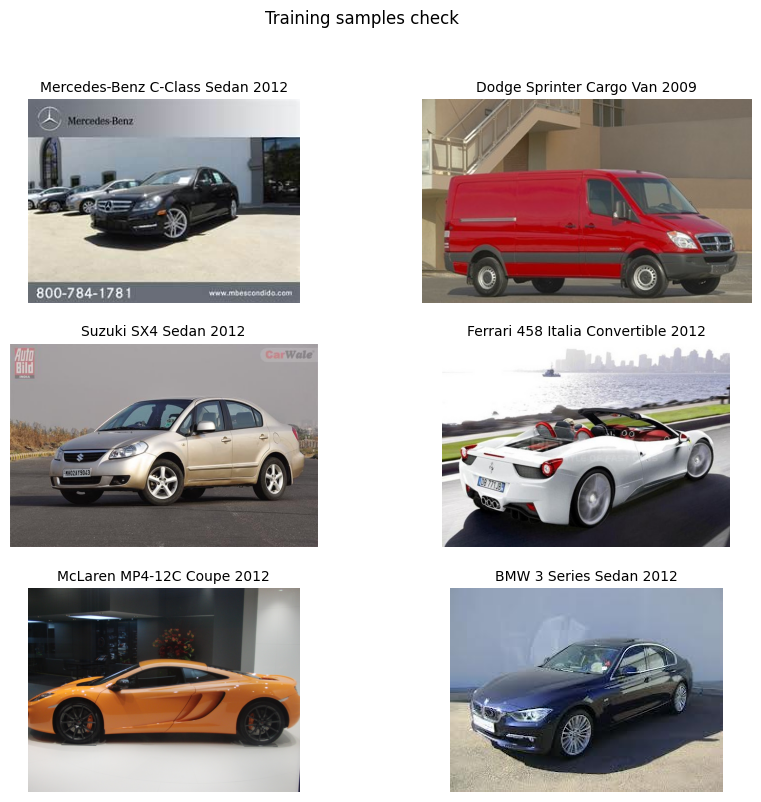

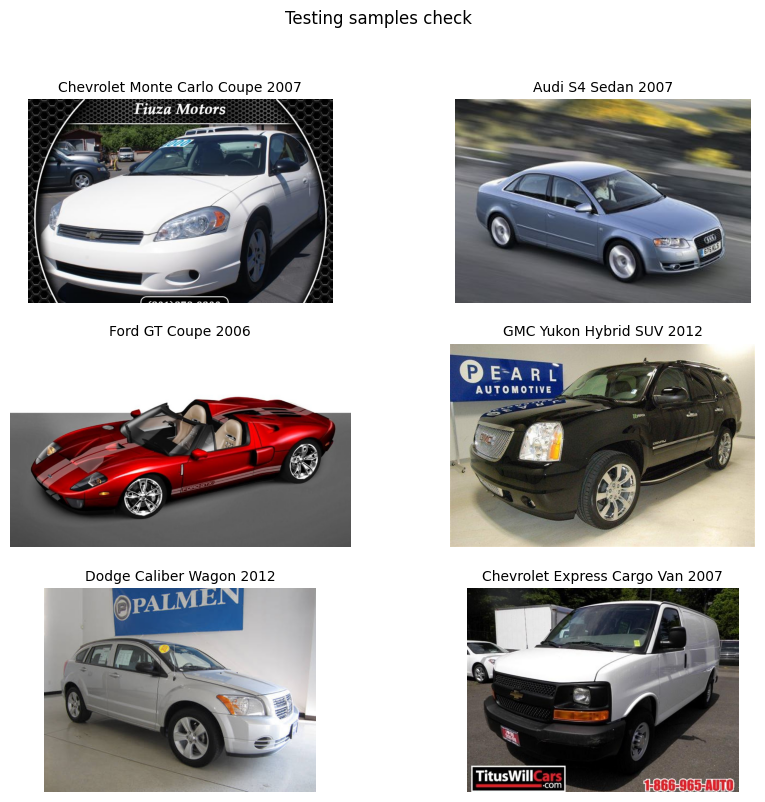

In [7]:
w, h = 2, 3
fig, axes_list = plt.subplots(h, w, figsize=(5*w, 3*h))
fig.suptitle('Training samples check')

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        random_index = random.randint(0, 500)
        random_sample = cars_annos_train_mat['annotations'][0][random_index]
        sample_path, sample_class = random_sample[-1][0], random_sample[-2][0][0] - 1
        im = Image.open(os.path.join(cars_train, sample_path))
        ax.imshow(im)
        ax.set_title(class_names[sample_class], fontdict={"fontsize": 10})

fig, axes_list = plt.subplots(h, w, figsize=(5*w, 3*h))
fig.suptitle('Testing samples check')

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        random_index = random.randint(0, 500)
        random_sample = cars_annos_test_mat['annotations'][0][random_index]
        sample_path, sample_class = random_sample[-1][0], random_sample[-2][0][0] - 1
        im = Image.open(os.path.join(cars_test, sample_path))
        ax.imshow(im)
        ax.set_title(class_names[sample_class], fontdict={"fontsize": 10})

In [8]:
training_image_label_dictionary = {k: v for k, v in training_image_label_dictionary.items() if v <= 100}
testing_image_label_dictionary = {k: v for k, v in testing_image_label_dictionary.items() if v <= 100}


#### Define custom dataset class

In [10]:
class StanfordCarsCustomDataset(Dataset):
    def __init__(self, directory, image_label_dict, transform=None):
        self.directory = directory
        self.image_label_dict = image_label_dict
        self.transform = transform
        self.images = [img for img in os.listdir(directory) if img in image_label_dict]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join(self.directory, image_name)

        try:
            # Load the image in RGB format to match expected channels
            image = Image.open(image_path).convert('RGB')
            label = self.image_label_dict[image_name]
        except (KeyError, FileNotFoundError):
            # Skip this sample if label is not found or file is not present
            return None, None

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
def custom_collate_fn(batch):
    # Filter out None values
    batch = list(filter(lambda x: x[0] is not None and x[1] is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

Two transformations. One for simple CNN and one for more complex one

In [13]:
# Transformation for simple net cnn
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert images to tensors (RGB channels)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Transformation for simple net cnn2
transform2 = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),  # Resize with bilinear interpolation
            transforms.CenterCrop(224),  # Central crop to 224x224
            transforms.ToTensor(),       # Convert image to tensor and scale to [0.0, 1.0]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#### Choose the model name out of three

In [14]:
model = "google" # Options: google, cnn1, cnn2

if model == "google":
  train_dset = StanfordCarsCustomDataset(cars_train, training_image_label_dictionary, googlenet_transforms)
  test_dset = StanfordCarsCustomDataset(cars_test, testing_image_label_dictionary, googlenet_transforms)
elif model == "cnn1":
  train_dset = StanfordCarsCustomDataset(cars_train, training_image_label_dictionary, transform)
  test_dset = StanfordCarsCustomDataset(cars_test, testing_image_label_dictionary, transform)
elif model == "cnn2":
  train_dset = StanfordCarsCustomDataset(cars_train, training_image_label_dictionary, transform2)
  test_dset = StanfordCarsCustomDataset(cars_test, testing_image_label_dictionary, transform2)


train_dloader = DataLoader(train_dset, batch_size=32, num_workers=2, shuffle=True, collate_fn=custom_collate_fn)
test_dloader = DataLoader(test_dset, batch_size=32, num_workers=2, collate_fn=custom_collate_fn)

# Googlenet 1 training

In [ ]:
#Set up loss function, optmizer, and training/testing loops

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=googlenet.parameters(), lr=0.001)
epochs = 5
train_accuracy_array=[]
train_loss_array=[]
test_accuracy_array=[]
test_loss_array=[]

for epoch in tqdm(range(epochs)):
    googlenet.train()
    train_loss, train_acc = 0, 0

    train_dloader_tqdm = tqdm(train_dloader, desc=f"Epoch {epoch+1}/{epochs} - Training")
    for (X, y) in train_dloader_tqdm:
        X, y = X.to(device), y.to(device)

        y_logits = googlenet(X)
        y_pred_labels = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_acc += (y == y_pred_labels).sum().item() / len(y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update tqdm description
        train_dloader_tqdm.set_postfix(loss=train_loss / len(train_dloader), accuracy=train_acc / len(train_dloader))



    train_loss /= len(train_dloader)
    train_acc /= len(train_dloader)
    train_accuracy_array.append(train_acc)
    train_loss_array.append(train_loss)

    # Testing loop
    googlenet.eval()
    test_loss, test_acc = 0, 0
    test_dloader_tqdm = tqdm(test_dloader, desc=f"Epoch {epoch+1}/{epochs} - Testing")
    with torch.inference_mode():
        for (A, b) in test_dloader_tqdm:
            A, b = A.to(device), b.to(device)
            b_logits = googlenet(A)
            b_pred_labels = torch.softmax(b_logits, dim=1).argmax(dim=1)
            test_loss += loss_fn(b_logits, b).item()
            test_acc += (b == b_pred_labels).sum().item() / len(b)

            test_dloader_tqdm.set_postfix(loss=test_loss / len(test_dloader), accuracy=test_acc / len(test_dloader))

    test_loss /= len(test_dloader)
    test_acc /= len(test_dloader)
    test_accuracy_array.append(test_acc)
    test_loss_array.append(test_loss)

    print(f"Epoch: {epoch} -> TrainLoss, TrainAcc: {train_loss}, {train_acc} && TestLoss, TestAcc: {test_loss}, {test_acc}")

Epoch 1/5 - Training: 100%|██████████| 130/130 [00:56<00:00,  2.28it/s, accuracy=0.198, loss=4.01]

 20%|██        | 1/5 [18:45<1:15:03, 1125.83s/it]

Epoch: 0 -> TrainLoss, TrainAcc: 4.006481310037466, 0.19811126373626373 && TestLoss, TestAcc: 3.87738486038622, 0.2131782945736434



Epoch 2/5 - Training: 100%|██████████| 130/130 [00:55<00:00,  2.34it/s, accuracy=0.322, loss=3.53]

 40%|████      | 2/5 [20:37<26:27, 529.32s/it]   

Epoch: 1 -> TrainLoss, TrainAcc: 3.5326173543930053, 0.3216346153846154 && TestLoss, TestAcc: 3.7062071164449057, 0.24539728682170542



Epoch 3/5 - Training: 100%|██████████| 130/130 [00:55<00:00,  2.35it/s, accuracy=0.413, loss=3.21]

 60%|██████    | 3/5 [22:27<11:15, 337.88s/it]

Epoch: 2 -> TrainLoss, TrainAcc: 3.2135486877881565, 0.4128777472527473 && TestLoss, TestAcc: 3.506901497064635, 0.280765503875969



Epoch 4/5 - Training: 100%|██████████| 130/130 [00:54<00:00,  2.57it/s, accuracy=0.477, loss=2.97]

In [ ]:
model_save_path = 'googlenet_trained2.pth'

# Save the model's state dictionary
torch.save(googlenet.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to googlenet_trained2.pth


In [ ]:
torch.save({
    'epoch': epoch,  # current epoch number
    'model_state_dict': googlenet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': test_loss,  # loss value
}, 'model_checkpoint.pth')

# Googlenet 2 training

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=googlenet.parameters(), lr=0.001)
epochs = 5

for epoch in range(epochs):
    googlenet.train()
    train_loss, train_acc = 0, 0
    num_batches = len(train_dloader)

    # Create a progress bar for the epoch
    epoch_progress = tqdm(enumerate(train_dloader), total=num_batches, desc=f'Epoch {epoch+1}/{epochs}')

    # Training loop
    for batch_idx, (X, y) in epoch_progress:
        if X is None or y is None:
            continue  # Skip this batch if it contains None values

        X, y = X.to(device), y.to(device)

        y_logits = googlenet(X)
        loss = loss_fn(y_logits, y)
        y_pred_labels = torch.max(y_logits, dim=1).indices
        train_loss += loss.item()
        train_acc += (y == y_pred_labels).sum().item() / y.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar with batch loss
        epoch_progress.set_postfix(loss=train_loss / (batch_idx + 1), acc=train_acc / (batch_idx + 1))

    # Compute average loss and accuracy for the epoch
    train_loss /= num_batches
    train_acc /= num_batches

    # Print the progress after each epoch
    print(f"Epoch {epoch+1}/{epochs} -> TrainLoss: {train_loss:.4f}, TrainAcc: {train_acc:.4f}")



Epoch 1/5: 100%|██████████| 255/255 [02:22<00:00,  1.79it/s, acc=0.165, loss=4.32]


Epoch 1/5 -> TrainLoss: 4.3170, TrainAcc: 0.1653


Epoch 2/5: 100%|██████████| 255/255 [02:02<00:00,  2.08it/s, acc=0.294, loss=3.73]

Epoch 2/5 -> TrainLoss: 3.7327, TrainAcc: 0.2944


Epoch 3/5: 100%|██████████| 255/255 [02:02<00:00,  2.08it/s, acc=0.384, loss=3.37]

Epoch 3/5 -> TrainLoss: 3.3659, TrainAcc: 0.3838


Epoch 4/5: 100%|██████████| 255/255 [02:02<00:00,  2.08it/s, acc=0.45, loss=3.12]


Epoch 4/5 -> TrainLoss: 3.1225, TrainAcc: 0.4501


Epoch 5/5: 100%|██████████| 255/255 [02:16<00:00,  1.86it/s, acc=0.494, loss=2.93]

Epoch 5/5 -> TrainLoss: 2.9326, TrainAcc: 0.4938

In [ ]:
model_save_path = 'googlenet_trained.pth'

# Save the model's state dictionary
torch.save(googlenet.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

# Google net 2 evaluation

In [ ]:

googlenet.eval()
test_loss, test_acc = 0, 0
num_samples = 0

# Ensure no gradients are calculated during evaluation
with torch.no_grad():
    # Create a progress bar for the evaluation loop
    progress_bar = tqdm(enumerate(test_dloader), total=len(test_dloader), desc='Evaluating')

    for batch_idx, (A, b) in progress_bar:
        if A is None or b is None:
            continue  # Skip this batch if it contains None values

        # Transfer data to device
        A, b = A.to(device, non_blocking=True), b.to(device, non_blocking=True)

        # Forward pass
        b_logits = googlenet(A)
        b_pred_labels = torch.max(b_logits, dim=1).indices

        # Calculate loss
        batch_loss = loss_fn(b_logits, b)
        test_loss += batch_loss.item()

        # Calculate accuracy
        correct_predictions = (b == b_pred_labels).sum().item()
        test_acc += correct_predictions
        num_samples += b.size(0)

        # Update progress bar
        progress_bar.set_postfix(loss=test_loss / (batch_idx + 1), acc=test_acc / num_samples)

# Compute average loss and accuracy
test_loss /= len(test_dloader)
test_acc /= num_samples


print(f"Epoch: {epoch} -> TrainLoss: {train_loss:.4f}, TrainAcc: {train_acc:.4f} && TestLoss: {test_loss:.4f}, TestAcc: {test_acc:.4f}")

Evaluating: 100%|██████████| 252/252 [59:13<00:00, 14.10s/it, acc=0.306, loss=3.53]

Epoch: 4 -> TrainLoss: 2.9326,

TrainAcc: 0.4938 &&

TestLoss: 3.5326,

TestAcc: 0.3057

#### Plot predictions

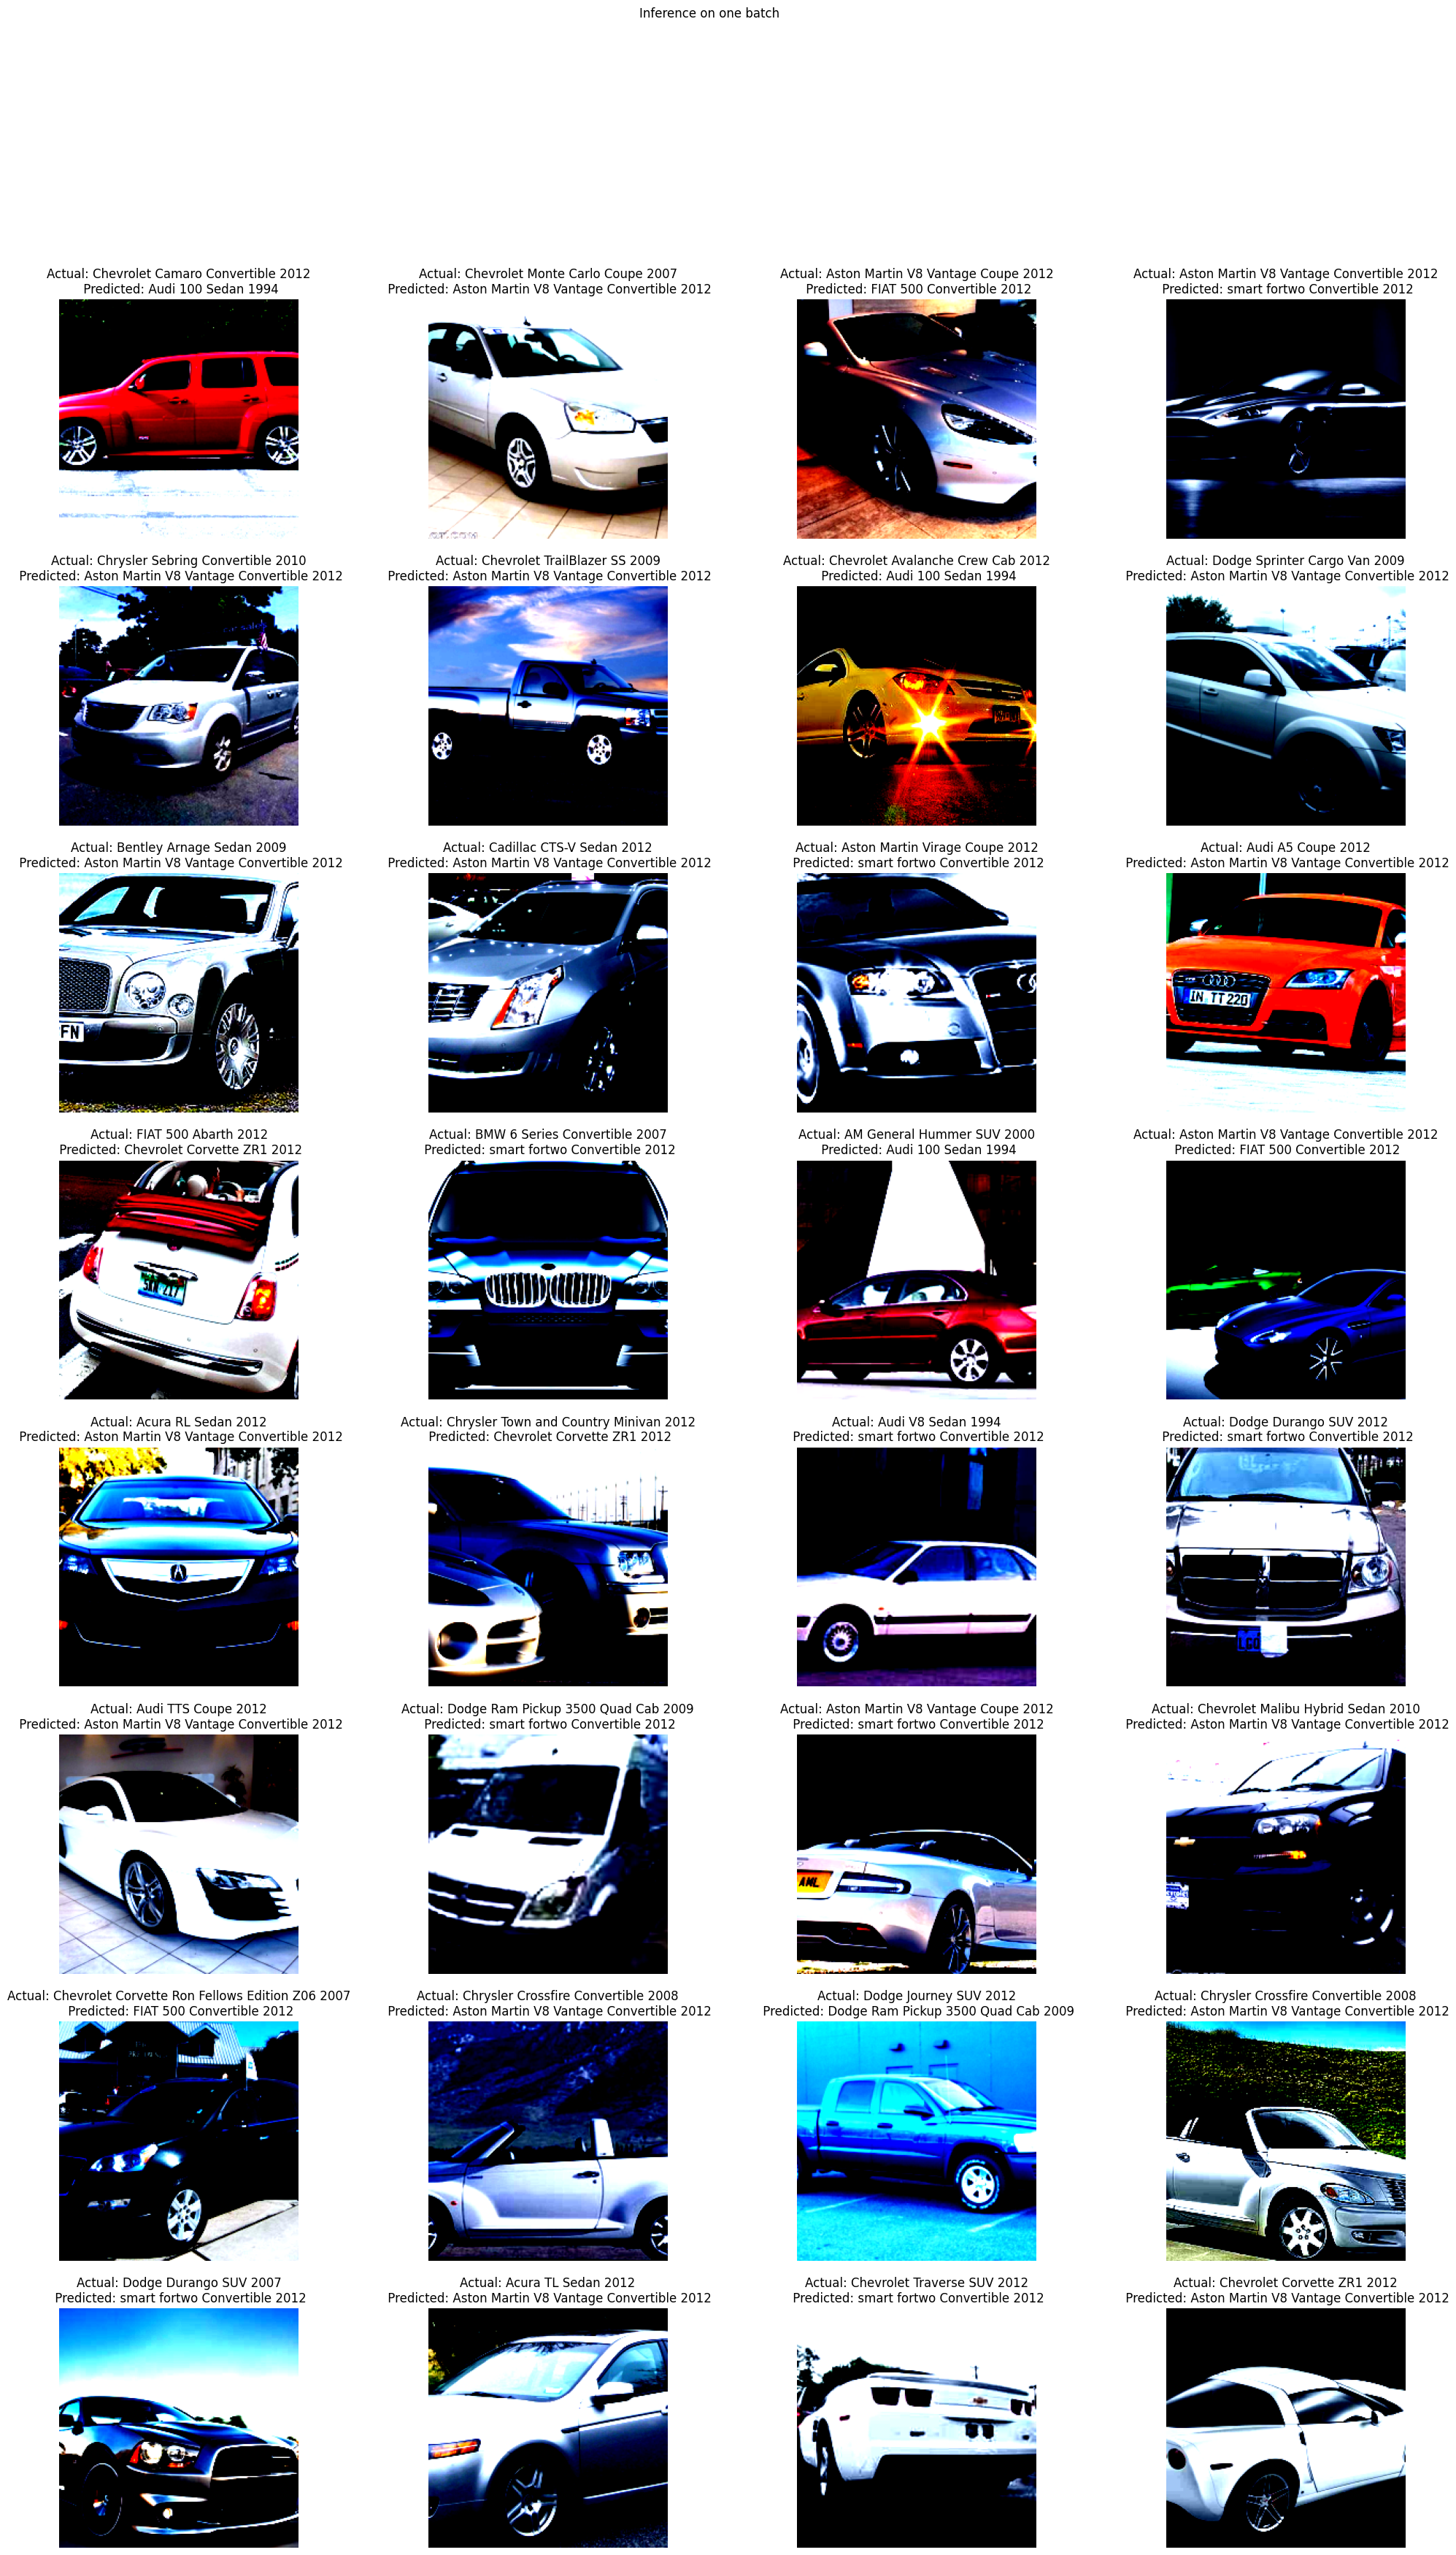

In [ ]:
with torch.inference_mode():
    imgs, labels = next(iter(test_dloader))
    imgs_transformed = googlenet_transforms(imgs)

    logits = googlenet(imgs_transformed.to(device))
    pred_probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(pred_probs, dim=1)

w, h = 4, 8
fig, axes_list = plt.subplots(h, w, figsize=(25, 40))
fig.suptitle('Inference on one batch')

axes_list = axes_list.flatten()

for i, img in enumerate(imgs):
    axes_list[i].imshow(img.permute(1, 2, 0))
    axes_list[i].axis('off')
    axes_list[i].set(title=f"Actual: {class_names[labels[i] - 1]}\n Predicted: {class_names[pred_label[i] - 1]}")

#### Simple CNN model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, num_classes)  # Adjusted dimensions for 32x32 input size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc1(x)
        return x

# Instantiate the model
num_classes = 101  # Replace with the number of classes in your dataset
simple_cnn = SimpleCNN(num_classes=num_classes).to(device)

In [ ]:
simple_cnn

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=101, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_cnn.parameters(), lr=0.001, momentum=0.9)
epochs = 10

for epoch in range(epochs):
    simple_cnn.train()
    train_loss, train_acc = 0, 0
    num_batches = len(train_dloader)

    # Create a progress bar for the epoch
    epoch_progress = tqdm(enumerate(train_dloader), total=num_batches, desc=f'Epoch {epoch+1}/{epochs}')

    # Training loop
    for batch_idx, (X, y) in epoch_progress:
        if X is None or y is None:
            continue  # Skip this batch if it contains None values

        X, y = X.to(device), y.to(device)

        y_logits = simple_cnn(X)

        loss = loss_fn(y_logits, y)
        y_pred_labels = torch.max(y_logits, dim=1).indices
        train_loss += loss.item()
        train_acc += (y == y_pred_labels).sum().item() / y.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar with batch loss
        epoch_progress.set_postfix(loss=train_loss / (batch_idx + 1), acc=train_acc / (batch_idx + 1))

    # Compute average loss and accuracy for the epoch
    train_loss /= num_batches
    train_acc /= num_batches

    # Print the progress after each epoch
    print(f"Epoch {epoch+1}/{epochs} -> TrainLoss: {train_loss:.4f}, TrainAcc: {train_acc:.4f}")

Epoch 1/10: 100%|██████████| 130/130 [00:43<00:00,  2.97it/s, acc=0.00962, loss=4.63]


Epoch 1/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096


Epoch 2/10: 100%|██████████| 130/130 [00:42<00:00,  3.04it/s, acc=0.00962, loss=4.63]


Epoch 2/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096


Epoch 3/10: 100%|██████████| 130/130 [00:41<00:00,  3.14it/s, acc=0.00962, loss=4.63]


Epoch 3/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096


Epoch 4/10: 100%|██████████| 130/130 [00:42<00:00,  3.04it/s, acc=0.00965, loss=4.63]


Epoch 4/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096


Epoch 5/10: 100%|██████████| 130/130 [00:43<00:00,  2.96it/s, acc=0.00962, loss=4.63]


Epoch 5/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096


Epoch 6/10: 100%|██████████| 130/130 [00:43<00:00,  3.01it/s, acc=0.00962, loss=4.63]


Epoch 6/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096


Epoch 7/10: 100%|██████████| 130/130 [00:41<00:00,  3.11it/s, acc=0.00965, loss=4.63]


Epoch 7/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096


Epoch 8/10: 100%|██████████| 130/130 [00:41<00:00,  3.12it/s, acc=0.00965, loss=4.63]


Epoch 8/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096


Epoch 9/10: 100%|██████████| 130/130 [00:41<00:00,  3.14it/s, acc=0.00962, loss=4.63]


Epoch 9/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096


Epoch 10/10: 100%|██████████| 130/130 [00:42<00:00,  3.07it/s, acc=0.00962, loss=4.63]

Epoch 10/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096


Epoch 1/10: 100%|██████████| 130/130 [00:43<00:00,  2.97it/s, acc=0.00962, loss=4.63]
Epoch 1/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096
Epoch 2/10: 100%|██████████| 130/130 [00:42<00:00,  3.04it/s, acc=0.00962, loss=4.63]
Epoch 2/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096
Epoch 3/10: 100%|██████████| 130/130 [00:41<00:00,  3.14it/s, acc=0.00962, loss=4.63]
Epoch 3/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096
Epoch 4/10: 100%|██████████| 130/130 [00:42<00:00,  3.04it/s, acc=0.00965, loss=4.63]
Epoch 4/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096
Epoch 5/10: 100%|██████████| 130/130 [00:43<00:00,  2.96it/s, acc=0.00962, loss=4.63]
Epoch 5/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096
Epoch 6/10: 100%|██████████| 130/130 [00:43<00:00,  3.01it/s, acc=0.00962, loss=4.63]
Epoch 6/10 -> TrainLoss: 4.6295, TrainAcc: 0.0096
Epoch 7/10: 100%|██████████| 130/130 [00:41<00:00,  3.11it/s, acc=0.00965, loss=4.63]
Epoch 7/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096
Epoch 8/10: 100%|██████████| 130/130 [00:41<00:00,  3.12it/s, acc=0.00965, loss=4.63]
Epoch 8/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096
Epoch 9/10: 100%|██████████| 130/130 [00:41<00:00,  3.14it/s, acc=0.00962, loss=4.63]
Epoch 9/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096
Epoch 10/10: 100%|██████████| 130/130 [00:42<00:00,  3.07it/s, acc=0.00962, loss=4.63]Epoch 10/10 -> TrainLoss: 4.6294, TrainAcc: 0.0096

In [ ]:
simple_cnn.eval()
test_loss, test_acc, all_preds, all_labels = 0, 0, [], []
num_test_batches = len(test_dloader)

with torch.no_grad():
    for X, y in tqdm(test_dloader, desc="Evaluating"):
        if X is None or y is None:
            continue  # Skip this batch if it contains None values

        X, y = X.to(device), y.to(device)

        y_logits = simple_cnn(X)
        loss = loss_fn(y_logits, y)
        y_pred_labels = torch.max(y_logits, dim=1).indices
        test_loss += loss.item()
        test_acc += (y == y_pred_labels).sum().item() / y.size(0)

        all_preds.extend(y_pred_labels.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Compute average test loss and accuracy
test_loss /= num_test_batches
test_acc /= num_test_batches

# Compute F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print evaluation metrics
print(f"TestLoss: {test_loss:.4f}, TestAcc: {test_acc:.4f}, F1Score: {f1:.4f}")

Evaluating: 100%|██████████| 129/129 [26:36<00:00, 12.38s/it]

TestLoss: 4.6286, TestAcc: 0.0119, F1Score: 0.0034


Evaluating: 100%|██████████| 129/129 [26:36<00:00, 12.38s/it]TestLoss: 4.6286, TestAcc: 0.0119, F1Score: 0.0034

In [ ]:
torch.save(simple_cnn.state_dict(), 'model2.pth')
print("Model saved as simple_cnn.pth")

Model saved as simple_cnn.pth


In [ ]:
def load_model(model_class, model_path, device):
    model = model_class(num_classes=101)  # Instantiate the model with the number of classes
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load the state dict
    model.to(device)  # Move model to the appropriate device
    return model

# Load the model
simple_cnn = load_model(SimpleCNN, '/content/model2.pth', device)

#### Plot the results

Train Loader:


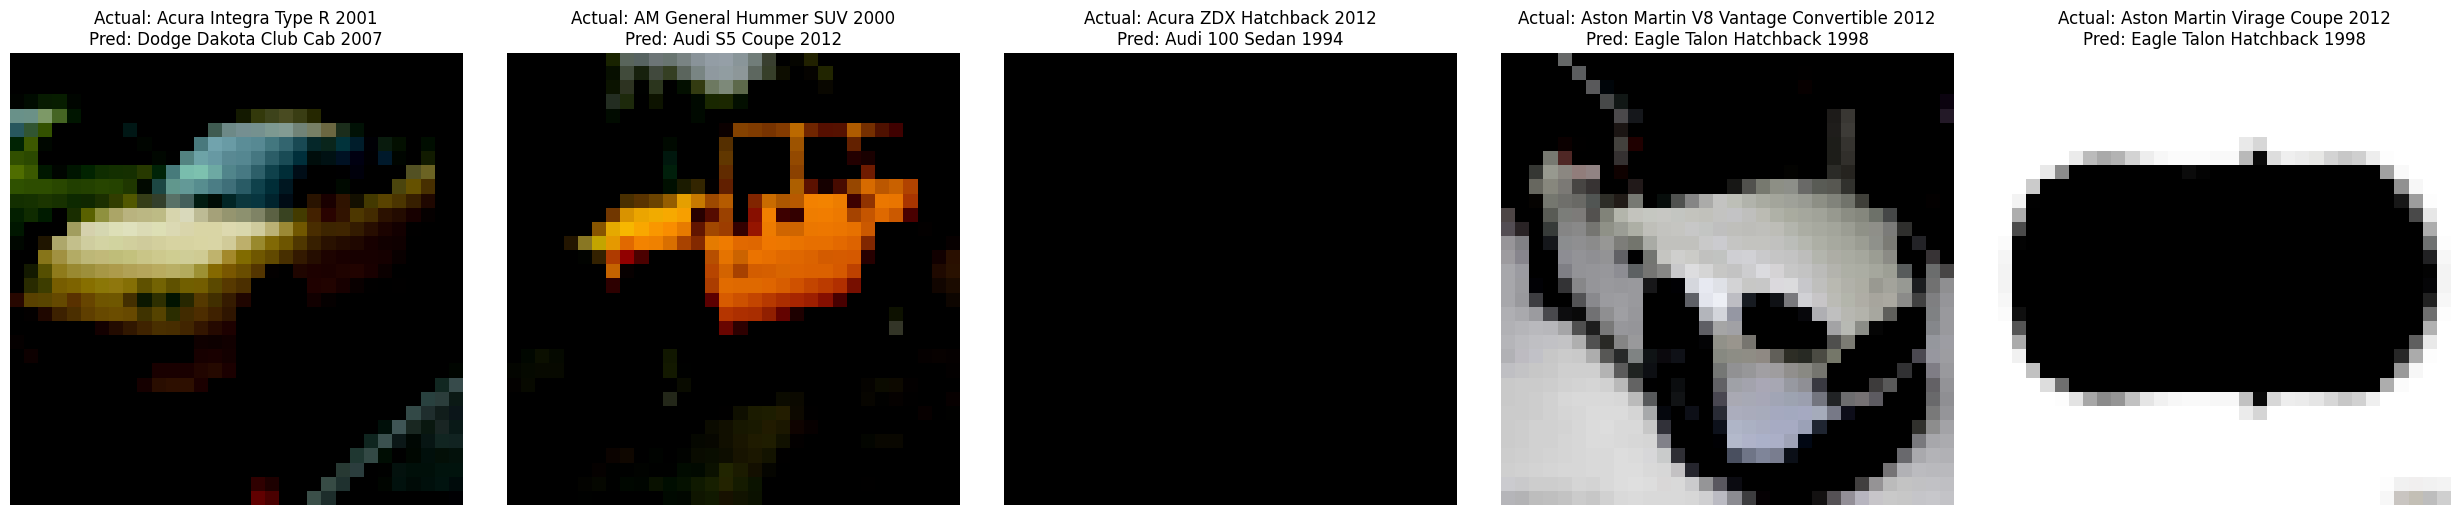

Test Loader:


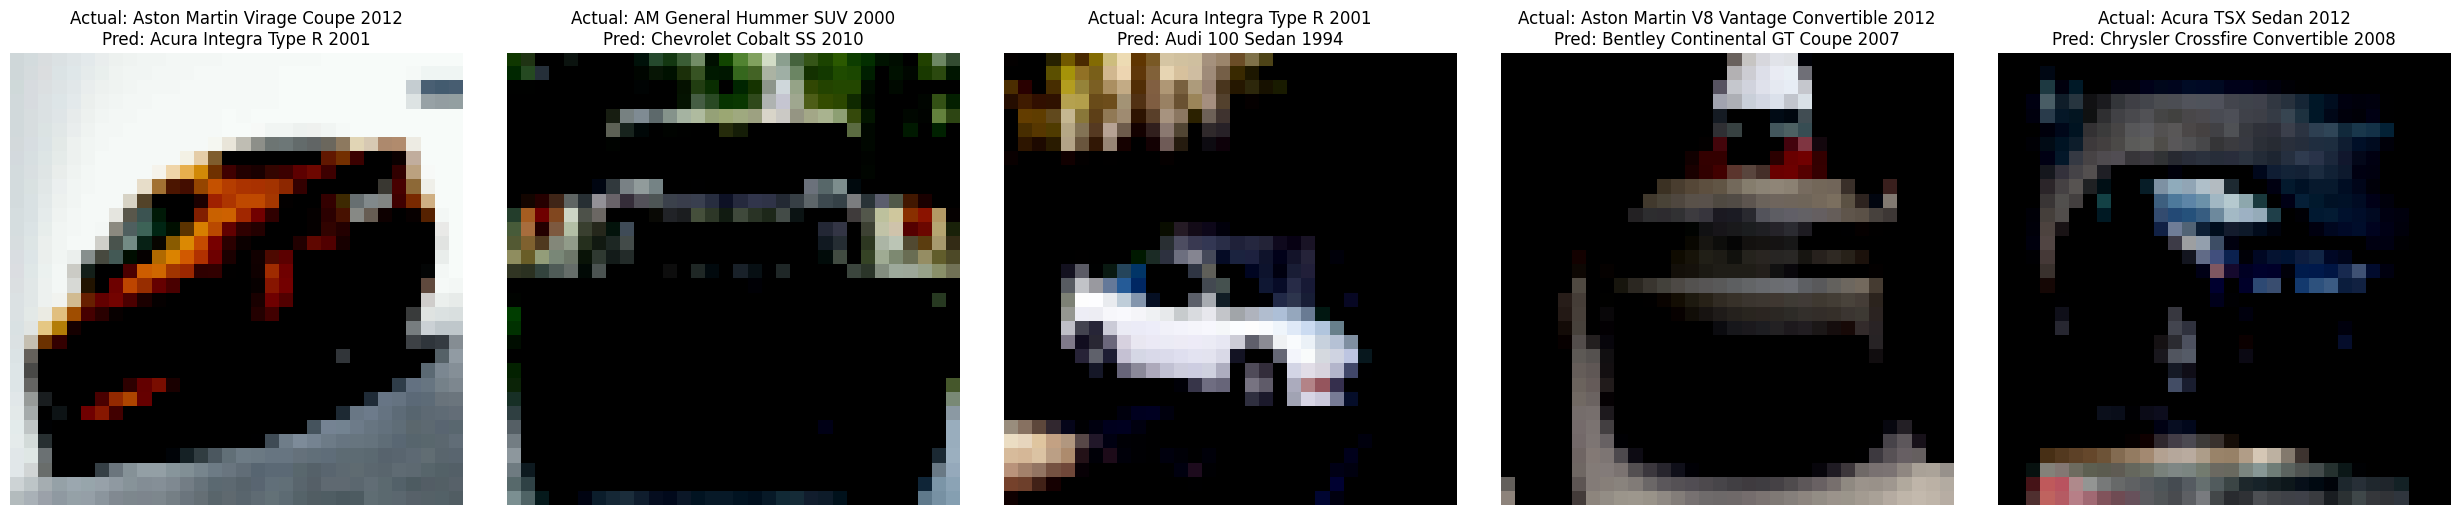

In [ ]:
# Function to show images in a grid
def plot_images_grid(images, actual_labels, predicted_labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(25, 5))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        actual_label = class_names[actual_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Actual: {actual_label}\nPred: {predicted_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Function to get a batch from loader and plot images
def print_actual_vs_predicted(loader, model, num_images=5):
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in loader:
            if X_batch is None or y_batch is None:
                continue  # Skip this batch if it contains None values

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_logits = model(X_batch)
            y_pred_labels = torch.max(y_logits, dim=1).indices

            # Get the actual and predicted labels
            actual_labels = y_batch.cpu().numpy()
            predicted_labels = y_pred_labels.cpu().numpy()

            # Plot the images
            plot_images_grid(X_batch, actual_labels, predicted_labels, num_images)

            break  # Only process the first batch

# # Print actual vs predicted for train loader
print("Train Loader:")
print_actual_vs_predicted(train_dloader, simple_cnn)

# Print actual vs predicted for test loader
print("Test Loader:")
print_actual_vs_predicted(test_dloader, simple_cnn)

Second CNN classification model

In [ ]:
class SimpleCNN2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN2, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)   # Output: (16, 224, 224)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)        # Output: (16, 112, 112)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Output: (32, 112, 112)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)       # Output: (32, 56, 56)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (64, 56, 56)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)       # Output: (64, 28, 28)
        # Adjust the Linear layer to match the number of classes
        self.fc1 = nn.Linear(64 * 28 * 28, num_classes)

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor with batch size dimension
        x = self.fc1(x)
        return x


simple_cnn2 = SimpleCNN2(num_classes=101).to(device)

In [ ]:
simple_cnn2

SimpleCNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=101, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_cnn2.parameters(), lr=0.001, momentum=0.9)
epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(epochs):
    simple_cnn2.train()
    train_loss, train_acc = 0, 0
    num_batches = len(train_dloader)

    # Create a progress bar for the epoch
    epoch_progress = tqdm(enumerate(train_dloader), total=num_batches, desc=f'Epoch {epoch+1}/{epochs}')

    # Training loop
    for batch_idx, (X, y) in epoch_progress:
        if X is None or y is None:
            continue  # Skip this batch if it contains None values

        X, y = X.to(device), y.to(device)

        y_logits = simple_cnn2(X)
        # Print shapes for debugging
        loss = loss_fn(y_logits, y)
        y_pred_labels = torch.max(y_logits, dim=1).indices
        train_loss += loss.item()
        train_acc += (y == y_pred_labels).sum().item() / y.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar with batch loss
        epoch_progress.set_postfix(loss=train_loss / (batch_idx + 1), acc=train_acc / (batch_idx + 1))

    # Compute average loss and accuracy for the epoch
    train_loss /= num_batches
    train_acc /= num_batches
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Print the progress after each epoch
    print(f"Epoch {epoch+1}/{epochs} -> TrainLoss: {train_loss:.4f}, TrainAcc: {train_acc:.4f}")

Epoch 1/10: 100%|██████████| 130/130 [01:01<00:00,  2.10it/s, acc=0.00962, loss=4.62]


Epoch 1/10 -> TrainLoss: 4.6225, TrainAcc: 0.0096


Epoch 2/10: 100%|██████████| 130/130 [00:51<00:00,  2.54it/s, acc=0.02, loss=4.58]


Epoch 2/10 -> TrainLoss: 4.5828, TrainAcc: 0.0200


Epoch 3/10: 100%|██████████| 130/130 [00:52<00:00,  2.48it/s, acc=0.0361, loss=4.5]


Epoch 3/10 -> TrainLoss: 4.4960, TrainAcc: 0.0361


Epoch 4/10: 100%|██████████| 130/130 [00:51<00:00,  2.52it/s, acc=0.0548, loss=4.33]


Epoch 4/10 -> TrainLoss: 4.3313, TrainAcc: 0.0548


Epoch 5/10: 100%|██████████| 130/130 [00:49<00:00,  2.60it/s, acc=0.0934, loss=4.12]


Epoch 5/10 -> TrainLoss: 4.1180, TrainAcc: 0.0934


Epoch 6/10: 100%|██████████| 130/130 [00:53<00:00,  2.44it/s, acc=0.137, loss=3.87]


Epoch 6/10 -> TrainLoss: 3.8674, TrainAcc: 0.1366


Epoch 7/10: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s, acc=0.218, loss=3.46]


Epoch 7/10 -> TrainLoss: 3.4632, TrainAcc: 0.2184


Epoch 8/10: 100%|██████████| 130/130 [00:50<00:00,  2.56it/s, acc=0.331, loss=2.78]


Epoch 8/10 -> TrainLoss: 2.7753, TrainAcc: 0.3308


Epoch 9/10: 100%|██████████| 130/130 [00:52<00:00,  2.47it/s, acc=0.606, loss=1.64]


Epoch 9/10 -> TrainLoss: 1.6377, TrainAcc: 0.6056


Epoch 10/10: 100%|██████████| 130/130 [00:52<00:00,  2.47it/s, acc=0.86, loss=0.574]

Epoch 10/10 -> TrainLoss: 0.5735, TrainAcc: 0.8600



Epoch 1/10: 100%|██████████| 130/130 [01:01<00:00,  2.10it/s, acc=0.00962, loss=4.62]
Epoch 1/10 -> TrainLoss: 4.6225, TrainAcc: 0.0096
Epoch 2/10: 100%|██████████| 130/130 [00:51<00:00,  2.54it/s, acc=0.02, loss=4.58]
Epoch 2/10 -> TrainLoss: 4.5828, TrainAcc: 0.0200
Epoch 3/10: 100%|██████████| 130/130 [00:52<00:00,  2.48it/s, acc=0.0361, loss=4.5]
Epoch 3/10 -> TrainLoss: 4.4960, TrainAcc: 0.0361
Epoch 4/10: 100%|██████████| 130/130 [00:51<00:00,  2.52it/s, acc=0.0548, loss=4.33]
Epoch 4/10 -> TrainLoss: 4.3313, TrainAcc: 0.0548
Epoch 5/10: 100%|██████████| 130/130 [00:49<00:00,  2.60it/s, acc=0.0934, loss=4.12]
Epoch 5/10 -> TrainLoss: 4.1180, TrainAcc: 0.0934
Epoch 6/10: 100%|██████████| 130/130 [00:53<00:00,  2.44it/s, acc=0.137, loss=3.87]
Epoch 6/10 -> TrainLoss: 3.8674, TrainAcc: 0.1366
Epoch 7/10: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s, acc=0.218, loss=3.46]
Epoch 7/10 -> TrainLoss: 3.4632, TrainAcc: 0.2184
Epoch 8/10: 100%|██████████| 130/130 [00:50<00:00,  2.56it/s, acc=0.331, loss=2.78]
Epoch 8/10 -> TrainLoss: 2.7753, TrainAcc: 0.3308
Epoch 9/10: 100%|██████████| 130/130 [00:52<00:00,  2.47it/s, acc=0.606, loss=1.64]
Epoch 9/10 -> TrainLoss: 1.6377, TrainAcc: 0.6056
Epoch 10/10: 100%|██████████| 130/130 [00:52<00:00,  2.47it/s, acc=0.86, loss=0.574]Epoch 10/10 -> TrainLoss: 0.5735, TrainAcc: 0.8600

In [ ]:
torch.save(simple_cnn2.state_dict(), 'model3.pth')
print("Model saved as simple_cnn.pth")

Model saved as simple_cnn.pth


In [ ]:
def load_model(model_class, model_path, device):
    model = model_class(num_classes=101)  # Instantiate the model with the number of classes
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load the state dict
    model.to(device)  # Move model to the appropriate device
    return model

# Load the model
simple_cnn2_loaded = load_model(SimpleCNN2, '/content/model3.pth', device)

Train Loader:


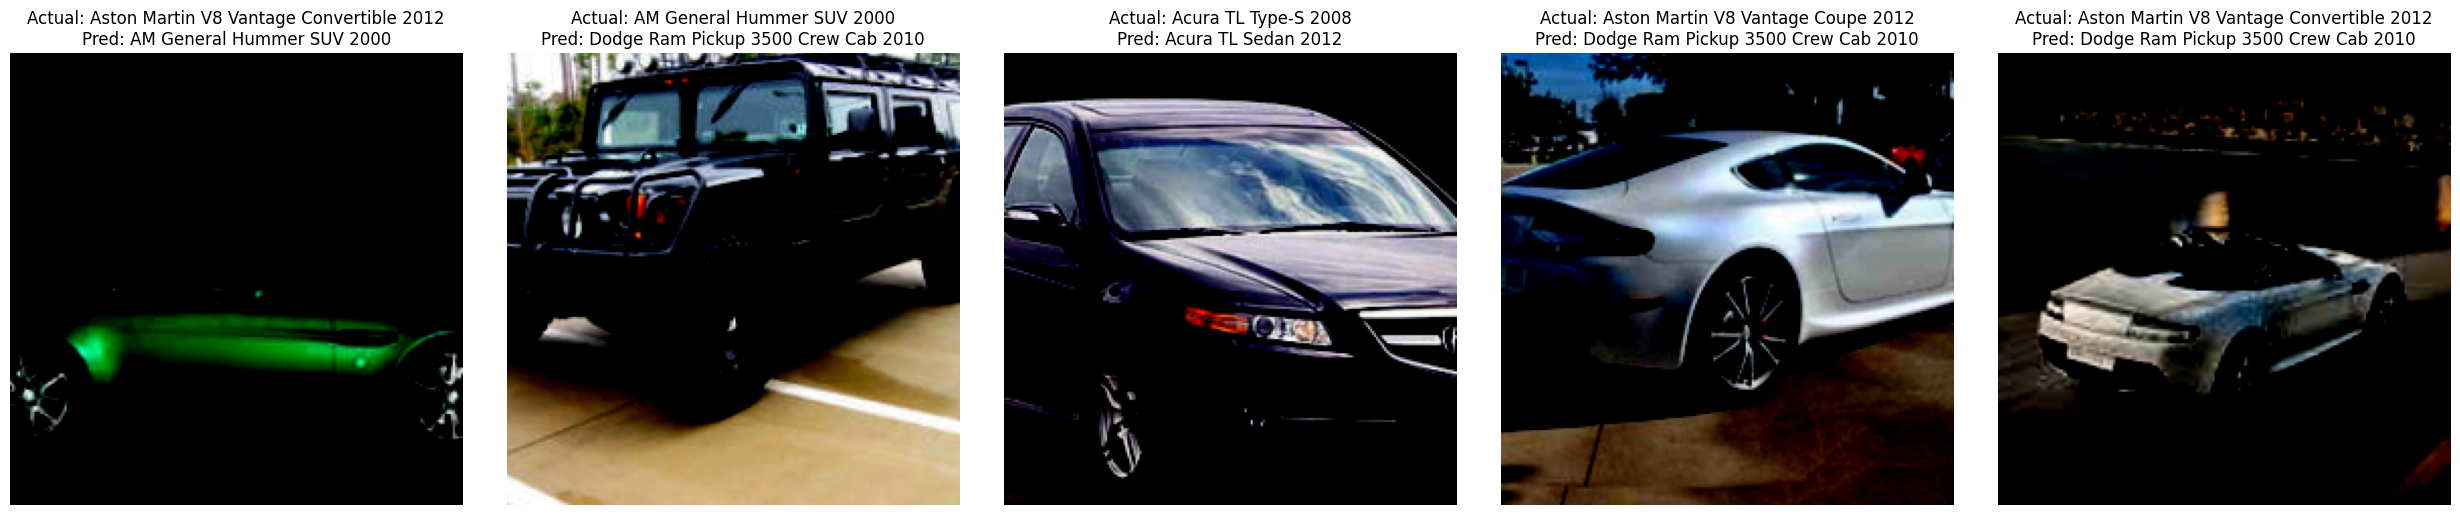

Test Loader:


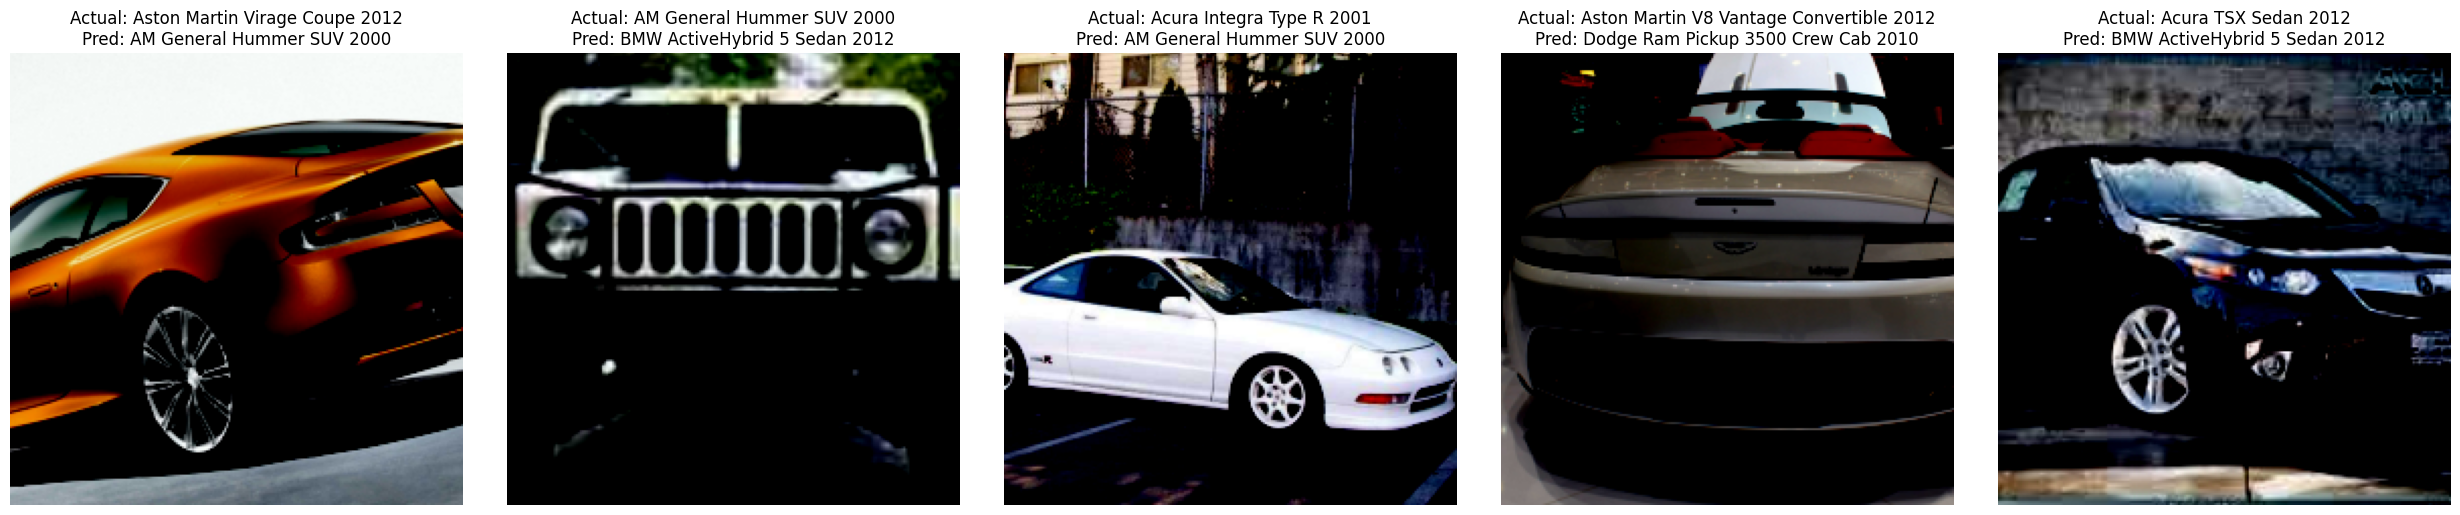

In [ ]:
# Print actual vs predicted for train loader
print("Train Loader:")
print_actual_vs_predicted(train_dloader, simple_cnn2)

# Print actual vs predicted for test loader
print("Test Loader:")
print_actual_vs_predicted(test_dloader, simple_cnn2)